In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [100]:
df = pd.read_csv('training.csv')

In [101]:
# Transfer variable type we need, take drillbit_size as an ordinal categorical variable
df['drillbit_size'] = df['drillbit_size'].astype(object)
y = df['rate_of_penetration']
X = df[['drillbit_size','min_depth','surface_weight_on_bit','surface_rpm']]

In [102]:
X.head()

,drillbit_size,min_depth,surface_weight_on_bit,surface_rpm
0,12.25,21834.5,43.533280,150.369091
1,12.25,21840.0,42.382033,150.369001
2,12.25,21870.0,48.675129,150.429335
3,12.25,21900.0,30.041290,150.080000
4,12.25,21930.0,31.406319,150.032167


In [103]:
X.shape

(6838, 4)

In [104]:
# Encode the ordinal categorical variable
X['drillbit_size'] = OrdinalEncoder().fit_transform(np.asarray(X['drillbit_size']).reshape(-1,1))
# Standardize numerical variables
X_std = pd.DataFrame(StandardScaler().fit_transform(X))
# X = pd.concat([X.iloc[:,:4], X_std], axis=1)
# One-hot encoding for non-ordinal categorical variables
# X = pd.get_dummies(X)

C:\Users\10256\AppData\Local\Temp/ipykernel_17888/4163686218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['drillbit_size'] = OrdinalEncoder().fit_transform(np.asarray(X['drillbit_size']).reshape(-1,1))


In [105]:
X.head()

,drillbit_size,min_depth,surface_weight_on_bit,surface_rpm
0,2.0,21834.5,43.533280,150.369091
1,2.0,21840.0,42.382033,150.369001
2,2.0,21870.0,48.675129,150.429335
3,2.0,21900.0,30.041290,150.080000
4,2.0,21930.0,31.406319,150.032167


## Reduce Dimentions

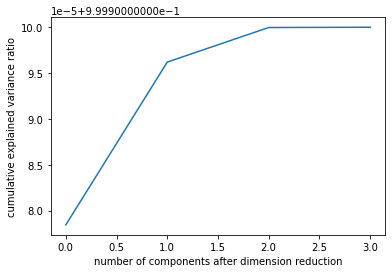

In [106]:
# Use PCA method. Find the optimal number of components
from sklearn.decomposition import PCA
pca_line = PCA().fit(X)
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("number of components after dimension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [108]:
X_dr = pd.DataFrame(PCA(3).fit_transform(X))

## Model

In [109]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

In [110]:
# Split the training and testing dataset
xtrain, xtest, ytrain, ytest = train_test_split(X_dr, y, test_size=0.25, random_state=17)

In [111]:
# Detect and delete outliers in the training set
lof = LocalOutlierFactor()
test_outlier = lof.fit_predict(xtrain)
mask = test_outlier != -1

In [112]:
xtrain.shape

(5128, 3)

In [113]:
ytrain = ytrain[mask]
xtrain = xtrain[mask]

In [114]:
reg = LR().fit(xtrain, ytrain)
yhat = reg.predict(xtest)

In [115]:
from sklearn.metrics import mean_squared_error as MSE
Rmse1 = MSE(yhat, ytest)**0.5
Rmse1

42.82924787021527

In [116]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

regr = MLPRegressor(random_state=17, max_iter=5000).fit(xtrain, ytrain)
yhatnn = regr.predict(xtest)
Rmse2 = MSE(yhatnn, ytest)**0.5
Rmse2

48.51135625857584

## Scoring

In [89]:
xscore = pd.read_csv('scoring.csv')
result = pd.read_csv('submission_format.csv')

In [117]:
xscore['drillbit_size'] = xscore['drillbit_size'].astype(object)
xscore['drillbit_size'] = OrdinalEncoder().fit_transform(np.asarray(xscore['drillbit_size']).reshape(-1,1))
Xscore = xscore[['drillbit_size','min_depth','surface_weight_on_bit','surface_rpm']]
X_score_dr = pd.DataFrame(PCA(3).fit_transform(Xscore))
yscore = regr.predict(X_score_dr)

In [118]:
result['rate_of_penetration'] = yscore

In [119]:
result

,segment_id,rate_of_penetration
0,wellbore_chev_no_14_665,61.336906
1,wellbore_chev_no_14_681,44.863293
2,wellbore_chev_no_14_682,41.765107
3,wellbore_chev_no_14_683,50.281349
4,wellbore_chev_no_14_684,43.696437
...,...,...
1562,wellbore_chev_no_7_780,62.928996
1563,wellbore_chev_no_7_781,72.063435
1564,wellbore_chev_no_7_782,73.653348
1565,wellbore_chev_no_7_783,68.320213


In [126]:
result.to_csv('result.csv')